In [112]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import polars as pl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_squared_error as mse
plt.ion()

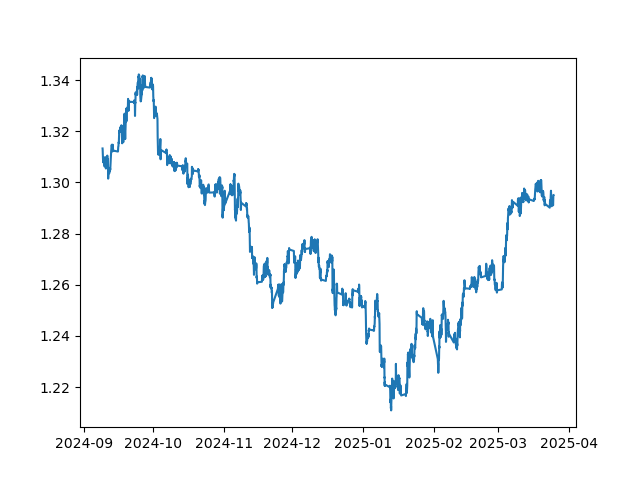

(3356, 1) (3356, 1)


In [2]:
fileName = "GBPUSD_M1.csv"
data = pd.read_csv(fileName)

priceData = pl.DataFrame(data[["Time", "Close"]]).select([
    pl.col("Time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M"),
    pl.col("Close")
])

priceData = (
    priceData.sort(by="Time")
    .group_by_dynamic("Time", every="1h")
    .agg(pl.col("Close").median())
    .drop_nulls()
)

timeSeries = priceData.select(pl.col("Time").dt.timestamp()).to_numpy()
priceSeries = priceData.select(pl.col("Close")).to_numpy()

fig = plt.figure(fileName)
plt.clf()
plt.plot([datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries[:,0]],priceSeries)
plt.title("")
plt.show()

print(timeSeries.shape, priceSeries.shape)

In [121]:
def plotGPR(timeSeries, meanSeries, stdSeries, onlyLatestValue):
    if onlyLatestValue: 
        color = 'darkorange'
        label1 = 'Predicted Mean'
        label2 = 'Predicted 95% Confidence'
    else: 
        color = 'darkgreen'
        label1 = 'True Mean'
        label2 = 'True 95% Confidence'
    
    plt.plot([datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries], meanSeries,color= color, label= label1)
    plt.fill_between(
        [datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries],
        meanSeries - 1.96 * stdSeries,
        meanSeries + 1.96 * stdSeries,
        alpha=0.5,
        color= color,
        label= label2
    )
    date_format = mdates.DateFormatter('%b %d')
    plt.gcf().axes[0].xaxis.set_major_formatter(date_format)
    plt.legend()


In [ ]:

def gprPredict(start, window, onlyLatestValue):
    projectSamples = 0
    
    X = timeSeries[start-window:start,0]
    y = priceSeries[start-window:start,0]

    if onlyLatestValue: return np.array([[X[-1], y[-1], .0005]])
    else: return np.column_stack((X, y, [.0005]*len(X)))


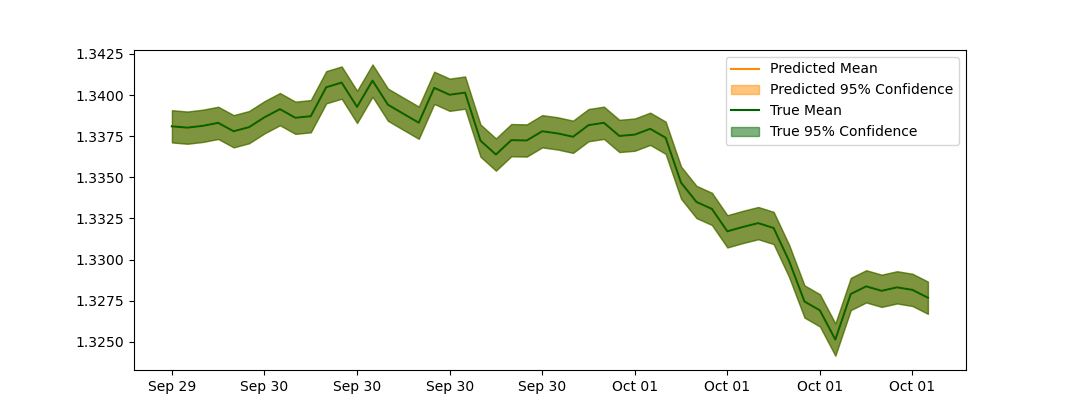

Predicted mean MSE, Predicted std MSE:  [0.0, 0.0]


In [129]:

# Backtest the GPR function.

startTime = -3000 # Number of hours in history
n = 100 # Number of samples to process per GPR
testRange = 50 # Number of GPR tests to conduct over time

predictSeries = gprPredict(startTime, n, True)
for i in range(1, testRange):
    predictSeries = np.vstack((predictSeries, gprPredict(startTime+i, n, True)))

trueSeries = gprPredict(startTime+testRange-1, n, False)
trueSeries = trueSeries[-testRange:]

fig = plt.figure(2)
plt.clf()
plotGPR(predictSeries[:,0], predictSeries[:,1], predictSeries[:,2], True)
plotGPR(trueSeries[:,0], trueSeries[:,1], trueSeries[:,2], False)
plt.show()

predictMSE = [mse(predictSeries[:,1], trueSeries[:,1]),mse(predictSeries[:,2], trueSeries[:,2])]

print("Predicted mean MSE, Predicted std MSE: ", predictMSE)

